In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('data/sample_submission.csv')
num_feature = df.columns.drop(['id', 'target'])
target = 'target'
df.target = df.target.clip(7,20)

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
df = df.iloc[~df.index.isin(lowest_quality_labels)]

df = df[df.target != 7]

In [16]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

import numpy as np

def standardize_data(data):
    """
    Standardize the input data (Z-score normalization).

    Parameters:
    - data (np.array): Input data to be standardized.

    Returns:
    - np.array: Standardized data.
    """
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    
    # Avoid division by zero by adding a small epsilon
    std_dev += 1e-7
    
    standardized_data = (data - mean) / std_dev
    return standardized_data

# Assuming the other parts of your code and the provided CustomDataset are above this
col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']
training_df = df[col_to_keep]
training_ds = CustomDataset(training_df)

# Convert CustomDataset to a numpy matrix
training_data_matrix = np.array([sample.astype(np.float32) for sample in training_ds])
training_df = pd.DataFrame(training_data_matrix)
training_ds = CustomDataset(training_df)

# Normalize the data matrix
normalized_data_matrix = standardize_data(training_data_matrix)

# Create a new CustomDataset with normalized data
normalized_df = pd.DataFrame(normalized_data_matrix)
normalized_training_ds = CustomDataset(normalized_df)


In [69]:
import torch as T
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(T.nn.Module):
    def __init__(self, input_dim=2, encoding_dim=32, dropout_rate=0.5):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, encoding_dim),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)
# Define the model
autoencoder = AutoEncoder(input_dim=4, encoding_dim=3, dropout_rate=0.0).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)  # Reduce LR every 30 epochs by 70%

cpu


In [61]:
def train(model, dataset, num_epochs=50, batch_size=32):
    dataloader = T.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_values = []
    
    best_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data in dataloader:
            data = data.to(device)  # Send data to GPU
            outputs = model(data)
            loss = loss_function(outputs, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        scheduler.step()  
        average_epoch_loss = epoch_loss / len(dataloader)

        if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()
        
        loss_values.append(average_epoch_loss)
        print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')


    model.load_state_dict(best_model)
    # Plotting
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Epoch 500/500, Loss: 0.0400, Best: 0.0400

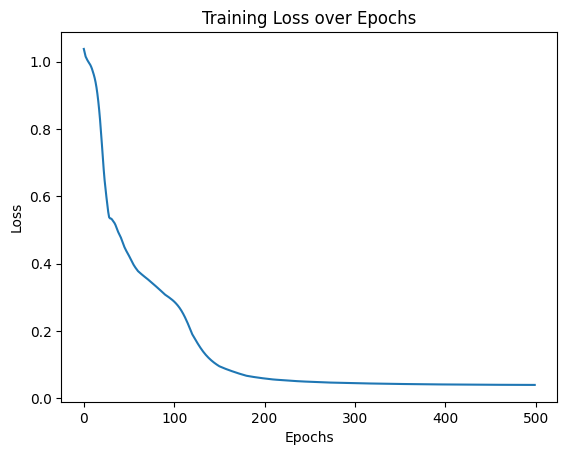

In [70]:
train(autoencoder, normalized_training_ds, num_epochs=500, batch_size=2983)

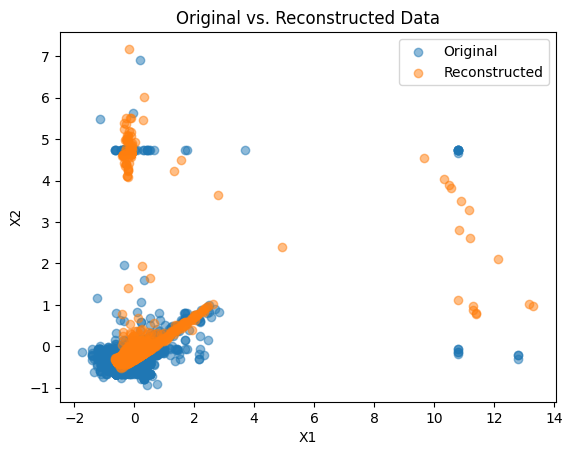

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# # Use DataLoader to handle the data transformation from Dataset to Tensor
dataloader_eval = T.utils.data.DataLoader(normalized_training_ds, batch_size=len(normalized_training_ds), shuffle=False)

reconstructed_data = []
autoencoder.eval()
# Visualize the results
with torch.no_grad():
    for data in dataloader_eval:
        outputs = autoencoder(data)
        reconstructed_data.append(outputs)
        
    reconstructed_data = T.cat(reconstructed_data).numpy()
    plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
    plt.title("Original vs. Reconstructed Data")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

Epoch 1000/1000, Loss: 3515.1050, Best: 3412.4663

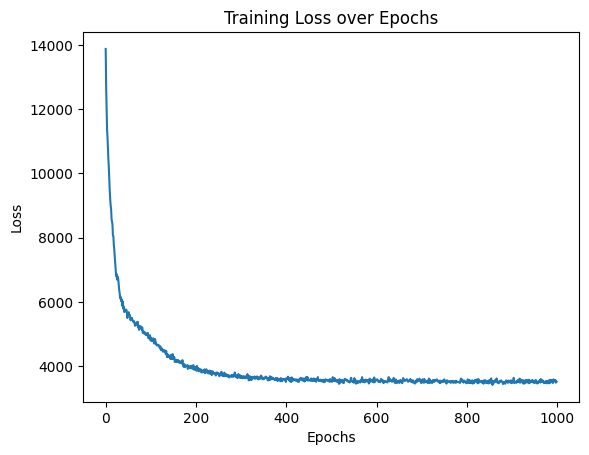

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

L = 25  # Adjust this based on your VAE architecture's latent space size

class VAE(nn.Module):
    def __init__(self, input_dim=4):
        self.input_dim = input_dim
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(self.input_dim, 25)
        self.fc2_mu = nn.Linear(25, L)
        self.fc2_logvar = nn.Linear(25, L)

        # Decoder
        self.fc3 = nn.Linear(L, 25)
        self.fc4 = nn.Linear(25, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar, beta=0.5):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD



# Training
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
beta = 0.5
dataloader = T.utils.data.DataLoader(normalized_training_ds, batch_size=2983, shuffle=True)
best_loss = np.inf
best_model = None
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in dataloader:
        data = data.to(device)
        model.train()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss = loss_function(recon_batch, data, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()

        epoch_loss = loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()

    loss_values.append(average_epoch_loss)
    print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')

model.load_state_dict(best_model)
# Plotting
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

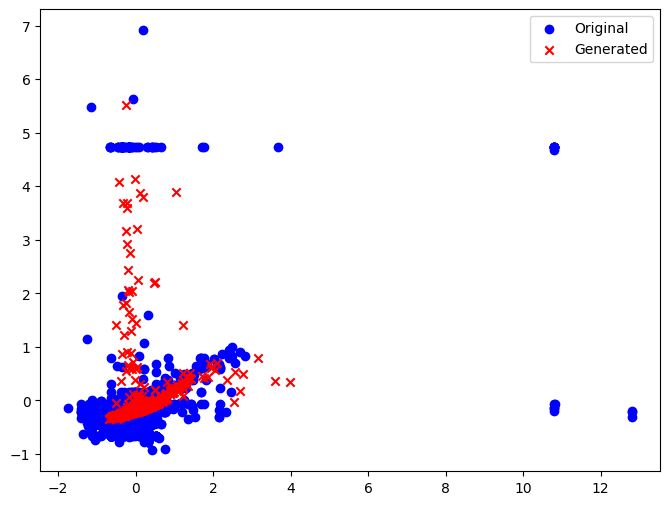

In [117]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # Sample from a standard normal distribution
    z = torch.randn(2000, L).to(device)
    generated_samples = model.decode(z).cpu().numpy()

    
original_samples = data[:100].numpy()

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter original samples
ax.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], c='blue', marker='o', label='Original')
# Scatter generated samples
ax.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', marker='x', label='Generated')

ax.legend()
plt.show()


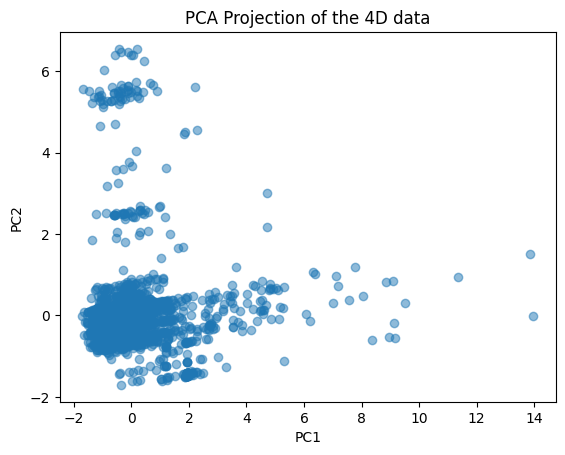

In [118]:
# Make a PCA on the normalized_df to display the 4 dimensions in 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(normalized_df)
pca_samples = pca.transform(normalized_df)

# Plot the 2D projection of the 4D data
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5)
plt.title("PCA Projection of the 4D data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

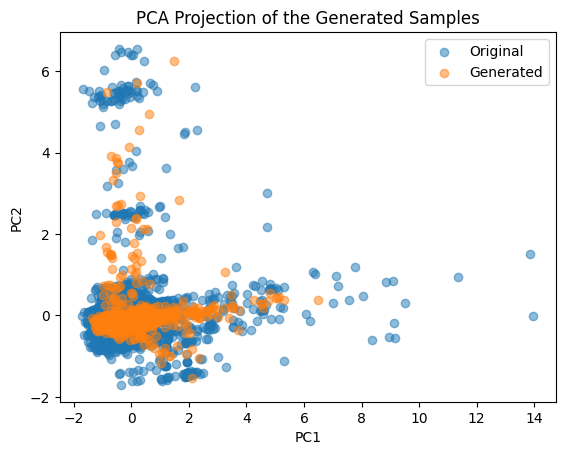

In [119]:
# With the same PCA, project the generated samples
pca_generated_samples = pca.transform(generated_samples)

# Plot the 2D projection of the generated samples
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5, label='Original')
plt.scatter(pca_generated_samples[:, 0], pca_generated_samples[:, 1], alpha=0.5, label='Generated')
plt.title("PCA Projection of the Generated Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()
